# Introducción

En esta sección implementaremos algoritmos de clustering sobre dos conjuntos de datos:

- Iris: Conjuntos de datos multivariable (setosa, versicolor, virginica)  el cual contiene las siguientes variables:
    - largo de sépalo;
    - ancho de sépalo;
    - largo de pétalo y;
    - ancho de pétalo.
    
- Wine: Conjunto de datos multivariable (class 0, class 1, class 2) el cual contiene las siguientes variables:
    - alcohol;
    - ácido málico; 
    - cenizas
    - alcalinidad de cenizas
    - magnesio
    - fenoles totales
    - flavonoides
    - fenoles no flavonoides
    - proantocianidinas
    - intensidad color
    - matiz
    - od280/od315 de vinos diluidos
    - prolina
    
Ambos conjuntos de datos son extraídos de la librería de **sklearn**.
 
Para este ejercicio intentaremos agrupar los datos utilizando las técnicas revisadas en la unidad 3A. Estas técnicas de clustering buscarán dividir el conjunto de datos en objetos similares y buscará separar los objetos que son diferentes. 

Para el presente ejercicio se utilizará un algoritmo particional (**K-Means**) y uno jerárquico para generar los clusters, en los algoritmos particionales se implementaran los métodos de **Elbow**, **Silueta** y **VAT** para determinar el número óptimo de clusters. Adicionalmente se compararan la calidad de los clusters obtenidos y se utilizarán las medidas internas y externas una vez que se haya hecho la agrupación de los datos.

# Desarrollo

## Cargan librerías necesarias para ambos conjuntos de datos

In [1]:
# Transformación de datos
import numpy as np
import pandas as pd
from sklearn import preprocessing

# Conjuntos de datos
from sklearn import datasets

# Importamos libería para clustering Jerárquico y KMeans 
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans

# Importamos librería para métricas
from sklearn.metrics import silhouette_score

# Importamos nuestra librería personalizada
from skeleton import *

In [4]:
def anota_dendograma(D, ax):
      bbox_props = dict(fc="white", ec="b",boxstyle='circle')
      ll=list(set(np.array(D['dcoord']).flatten()))
      ll.sort()
      for j, d in zip(D['icoord'], D['dcoord']):
        x = 0.5 * sum(j[1:3])
        y = d[1]
        #plt.plot(x, y, 'sr', markersize=10)
        ax.annotate("$C_{%d}$" %(ll.index(y)+len(X)-1) , (x, y), xytext=(0, 8),textcoords='offset points',va='top',size=9 
                     ,ha='center', bbox=bbox_props)

## Iris

Cargamos nuestro conjunto de datos y utilizando `preprocessing` normalizaremos los datos:

In [2]:
iris = datasets.load_iris()

# Normalizamos los datos
X = preprocessing.normalize(iris.data)

### Algortimo Jerárquico

El primer algoritmo que vamos a implementar es el cluster jerárquico usando el código que se compartió, recordemos que para este algoritmo existen 4 criterios de unión:
- Single;
- Complete;
- Centroid;
- Ward.

Omitiremos la función `anota_dendograma` ya que por la misma cantidad de datos que tenemo, la inclusión de la función dificulta la visualización de los resultados:

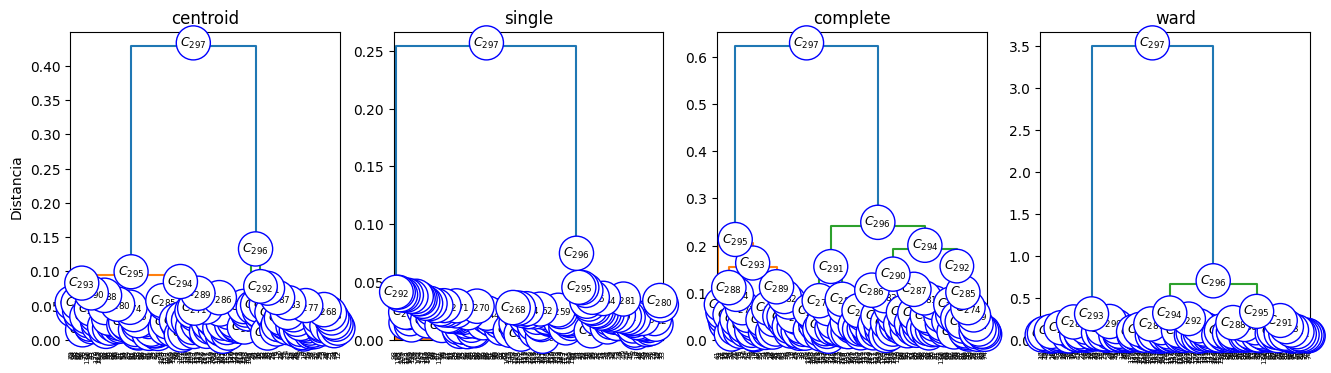

In [12]:
fig, axes = plt.subplots(1,4, figsize=(16,4))

axes[0].set_ylabel('Distancia')

linkage_type = ('centroid','single','complete', 'ward')

for i,lk in enumerate(linkage_type):
    
    Z = linkage(X, lk)
        
    Dz = dendrogram(Z, ax = axes[i])
    
    axes[i].set_title(lk)
        
    anota_dendograma(Dz,axes[i])

Utilizando este mismo método, intentaremos cortar el dendograma para formar nuestros clusters:

En centroid la ultima iteración se unen los clusters: (296.0, 297.0)
En centroid el costo es de: 0.4285181030443936
En centroid el número de elementos en C297 es: 150.0
En single la ultima iteración se unen los clusters: (293.0, 297.0)
En single el costo es de: 0.2537017722325306
En single el número de elementos en C297 es: 150.0
En complete la ultima iteración se unen los clusters: (296.0, 297.0)
En complete el costo es de: 0.6225109563040844
En complete el número de elementos en C297 es: 150.0
En ward la ultima iteración se unen los clusters: (294.0, 297.0)
En ward el costo es de: 3.498835660013823
En ward el número de elementos en C297 es: 150.0


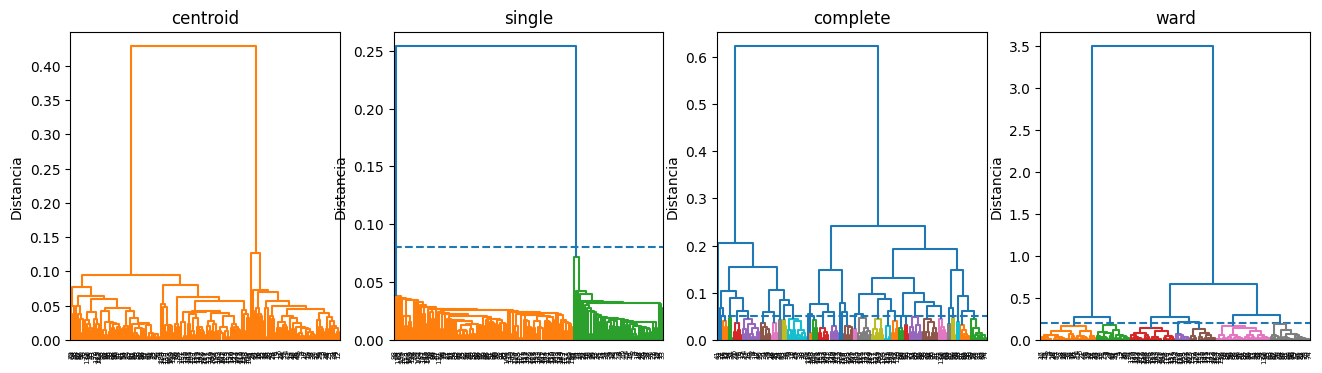

In [13]:
fig, axes = plt.subplots(1,4, figsize=(16,4))

linkage_type = ('centroid','single','complete', 'ward')
cutoff = (0.5, 0.08, 0.05, 0.2)
indexador = 0

for i in range(0,4):

    Z = linkage(X, linkage_type[i])
    axes[indexador].axhline(cutoff[i],
                            0,
                            5,
                            linestyle = 'dashed')
    Dz=dendrogram(Z, 
                  color_threshold = cutoff[i], 
                  ax = axes[indexador])
    
    axes[indexador].set_ylabel('Distancia')
    axes[indexador].set_title(linkage_type[i])
    
    if indexador + 1 == 4:
        pass
    else:
        indexador += 1
        
    print(f"En {linkage_type[i]} la ultima iteración se unen los clusters:", (Z[148,0], Z[148,1]))
    print(f"En {linkage_type[i]} el costo es de:", Z[148,2])
    print(f"En {linkage_type[i]} el número de elementos en C297 es:", Z[148,3])

El criterio de unión *ward* minimiza el incremento de la varianza del clustering, como vemos, este criterio es el que al parecer, mejor separa los clusters teniendo un costo de 3.49.

Sabiendo el número de cluster procedemos a obtener las etiquetas mediante la función `fcluster`

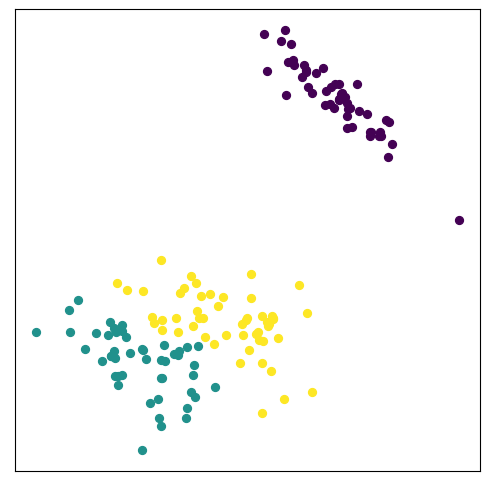

In [14]:
# Establecemos el número de clusters
clusters = 3 

# Obtenemos las etiqutas para cada cluster
y_hat = fcluster(Z, clusters, criterion='maxclust')

# Graficamos nuestro resultado
plotClusters(X, y_hat)

Como se puede apreciar, se han obtenido 3 clustres los cuales al parecer se encuentran bien diferenciados.

### K-Means

Ahora avanzaremos a la implementación del algortimo K-Means, pero sabiendo que existen los métodos **Elbow**, **Silueta** y **Tendencia de evaluación visual (VAT)** para determinar el número óptimo de clusters, primero procederemos a implementar dichos métodos: 

#### Elbow

Este método consiste en estimar la suma de los errores al cuadrado (SSE), la cúal es la distancia de todos los objetos con respecto de los centroides, y elegir el número de clusters dónde la diferencia haya sido mayor con respecto al número de clusters anterior, utilizaremos el método inertia_ para guardar el SSE:

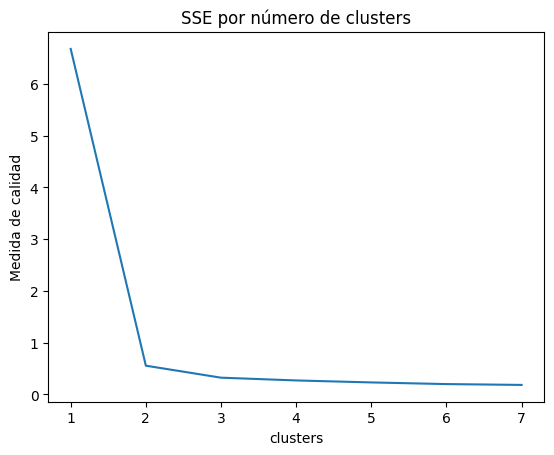

In [25]:
clusters = [x for x in range(1,8)]
score = []

for cluster in clusters:
    modelo_kmeans = KMeans(n_clusters = cluster)
    modelo_kmeans.fit(X)
    score.append(modelo_kmeans.inertia_)

fig, ax = plt.subplots(1, 1)
ax.set_xticks(clusters)
ax.set_title("SSE por número de clusters")
ax.set_xlabel('clusters')
ax.set_ylabel('Medida de calidad')
ax.plot(clusters, score)

#### Silueta

Este método minimiza la distancia de los elementos del cluster y busca maximizar la distancia entre clusters.

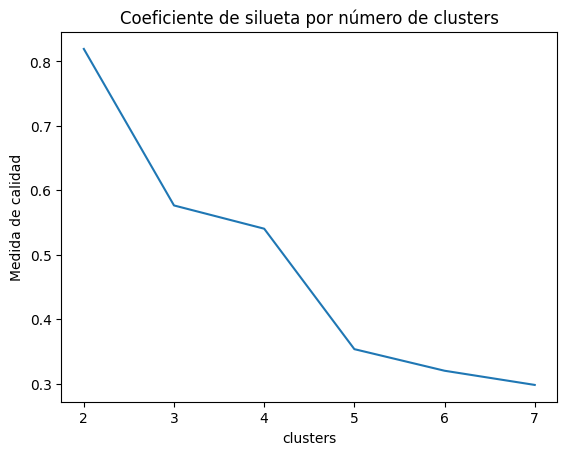

In [24]:
clusters = [x for x in range(2,8)]
lista_siluesta_score = []

for cluster in clusters:
    modelo_kmeans = KMeans(n_clusters = cluster)
    y_hat = modelo_kmeans.fit_predict(X)
    silueta_score = silhouette_score(X, y_hat)
    lista_siluesta_score.append(silueta_score)
    
fig, ax = plt.subplots(1, 1)
ax.set_xticks(clusters)
ax.plot(clusters, lista_siluesta_score)
ax.set_title("Coeficiente de silueta por número de clusters")
ax.set_xlabel('clusters')
ax.set_ylabel('Medida de calidad');

### VAT

Es un enfoque visual que nos permite ver nubes de puntos basadas en X:

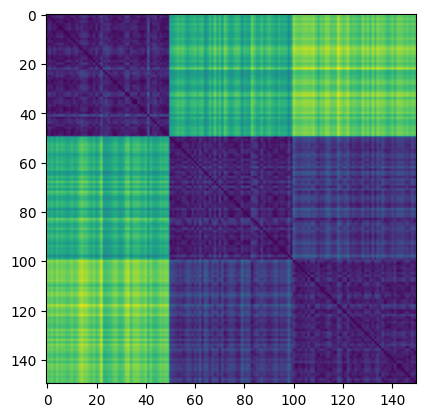

In [58]:
from scipy.spatial.distance import pdist, squareform

dist_euclidean = pdist(X, 'euclidean')

m = np.max(dist_euclidean)

n = len(X)

D = squareform(dist_euclidean)/m #Normalizamos entre el valor máximo

fig, ax = plt.subplots()
im = ax.imshow(D)

## K-Means 

Como podemos ver, en los 3 métodos para la elección del número de cluster óptimos, el resultado es 3, por lo que a continuación se presenta el algoritmo **K-Means** para 3 clusters:

Text(0.5, 1.0, 'Clusters = 3')

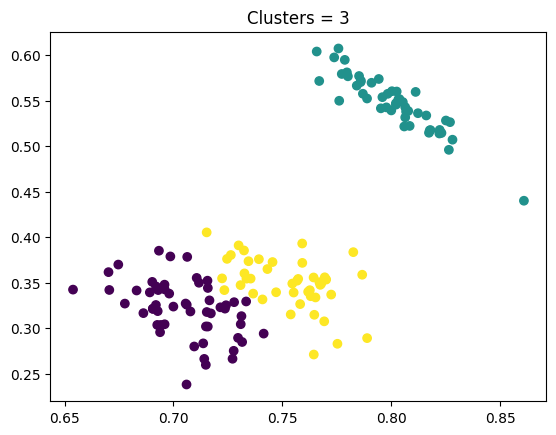

In [97]:
fig, ax = plt.subplots(1, 1)

model_kmeans = KMeans(n_clusters = 3)
y_hat = model_kmeans.fit_predict(X = X)
ax.scatter(x = X[:, 0],
           y = X[:, 1], 
           c = y_hat)

ax.set_title('Clusters = 3')

In [100]:
dist_euclidean.shape

(11175,)

In [101]:
import numpy as np

def fft(X,D,k):
    """
    X: input vectors (n_samples by dimensionality)
    D: distance matrix (n_samples by n_samples)
    k: number of centroids
    out: indices of centroids
    """
    n=X.shape[0]
    visited=[]
    i=np.int32(np.random.uniform(n))
    visited.append(i)
    while len(visited)<k:
        dist=np.mean([D[i] for i in visited],0)
        for i in np.argsort(dist)[::-1]:
            if i not in visited:
                visited.append(i)
                break
    return np.array(visited)

if __name__ == '__main__':
    import matplotlib.pyplot as plt
    n=300
    e=0.1
    mu1=np.array([-2.,0.])
    mu2=np.array([2.,0.])
    mu3=np.array([0.,2.])
    mu=np.array([mu1,mu2,mu3])
    x1=np.random.multivariate_normal(mu1,e*np.identity(2),n/3)
    x2=np.random.multivariate_normal(mu2,e*np.identity(2),n/3)
    x3=np.random.multivariate_normal(mu3,e*np.identity(2),n/3)
    X=np.r_[x1,x2,x3]
    y=np.concatenate([np.repeat(0,int(n/3)),np.repeat(1,int(n/3)),np.repeat(2,int(n/3))])

    X2=np.c_[np.sum(X**2,1)]
    D=X2+X2.T-2*X.dot(X.T)
    centroid_idx=fft(X,D,3)
    centroids=X[centroid_idx]

    colors=plt.cm.Paired(np.linspace(0, 1, len(np.unique(y))))
    plt.scatter(X[:,0],X[:,1],color=colors[y])
    plt.scatter(centroids[:,0],centroids[:,1],color="black",s=50)
    plt.show()

TypeError: 'float' object is unsliceable

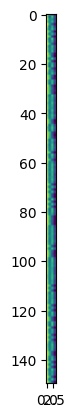

In [92]:
fig, ax = plt.subplots()
im = ax.imshow(findCenters(data = X, k =len(X)))